In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

НАСТРОЙКИ ПРОЕКТА

In [2]:

DATASET_PATH = "./generated_dataset"
IMG_SIZE = (45, 45)
IMAGES_PER_CHAR = 80
TRAIN_SPLIT = 0.8

SUPPORTED_CHARS = ['(', ')', '0','1','2','3','4','5','6','7','8','9',
                   't','x','y',',','+','-','*']

DISPLAY_MAP = {
    '(': '(',
    ')': ')',
    ',': ',',
    '*': '*',
    '+': '+',
    '-': '-',
    't': 't',
    'x': 'x',
    'y': 'y'
}

for d in '0123456789':
    DISPLAY_MAP[d] = d

ГЕНЕРАЦИЯ СИМВОЛОВ

In [3]:

def draw_character(char, size=IMG_SIZE):
    img = np.ones(size, np.uint8) * 255
    font = cv2.FONT_HERSHEY_SIMPLEX

    # параметры
    scale = 1.4
    thick = 2

    (tw, th), base = cv2.getTextSize(DISPLAY_MAP[char], font, scale, thick)
    x = (size[1] - tw) // 2
    y = (size[0] + th) // 2

    cv2.putText(img, DISPLAY_MAP[char], (x, y), font, scale, 0, thick)

    return img


def augment_image(img):
    choice = random.randint(0, 2)

    if choice == 0:
        noise = np.random.normal(0, 12, img.shape).astype(np.int16)
        img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    elif choice == 1:
        angle = random.uniform(-12, 12)
        M = cv2.getRotationMatrix2D((IMG_SIZE[1]//2, IMG_SIZE[0]//2), angle, 1.0)
        img = cv2.warpAffine(img, M, IMG_SIZE, borderValue=255)

    else:
        kernel = np.ones((2,2), np.uint8)
        if random.random() > 0.5:
            img = cv2.erode(img, kernel, 1)
        else:
            img = cv2.dilate(img, kernel, 1)

    return img


def generate_dataset():
    os.makedirs(DATASET_PATH, exist_ok=True)

    for char in SUPPORTED_CHARS:
        folder = os.path.join(DATASET_PATH, char)
        os.makedirs(folder, exist_ok=True)

        for i in range(IMAGES_PER_CHAR):
            base = draw_character(char)
            img = augment_image(base)
            cv2.imwrite(os.path.join(folder, f"{char}_{i:03d}.png"), img)

    print("Датасет успешно создан!")

ПОДГОТОВКА ТРЕНИРОВОЧНЫХ ДАННЫХ KNN

In [4]:
def load_training_data():
    X, y = [], []

    for char in SUPPORTED_CHARS:
        folder = os.path.join(DATASET_PATH, char)
        files = sorted(os.listdir(folder))

        split = int(len(files) * TRAIN_SPLIT)
        train_files = files[:split]

        for f in train_files:
            img = cv2.imread(os.path.join(folder,f), cv2.IMREAD_GRAYSCALE)
            X.append(img.flatten())
            y.append(char)

    return np.array(X), np.array(y)

ОБУЧЕНИЕ KNN

In [5]:
def train_knn_models(X_train, y_train, k_values=[1,3,5,7,9]):
    models = {}
    for k in k_values:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train, y_train)
        models[k] = clf
        print(f"KNN k={k} обучен.")
    return models

ГЕНЕРАЦИЯ СЛУЧАЙНЫХ ТЕКСТОВЫХ СТРОК

In [6]:
def generate_random_text(min_len=5, max_len=12):
    length = random.randint(min_len, max_len)
    text = ''.join(random.choices(SUPPORTED_CHARS, k=length))
    return text


def generate_text_image(text, gap=25):
    """Создать изображение всей строки."""
    chars = [draw_character(c) for c in text]
    widths = [c.shape[1] for c in chars]
    total_w = sum(widths) + gap*(len(chars)-1)
    max_h = max(c.shape[0] for c in chars)

    img = np.ones((max_h, total_w), np.uint8) * 255

    x = 0
    for c in chars:
        h, w = c.shape
        y = max_h - h
        img[y:y+h, x:x+w] = c
        x += w + gap

    return img

ВЫДЕЛЕНИЕ СИМВОЛОВ

In [7]:
def extract_characters(line_image):
    img = cv2.bitwise_not(line_image)

    _, bin_img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        if w*h > 40:
            boxes.append((x,y,w,h))

    boxes.sort(key=lambda b: b[0])

    chars = []
    for x,y,w,h in boxes:
        crop = img[y:y+h, x:x+w]
        crop = cv2.resize(crop, IMG_SIZE)
        chars.append((x, crop))

    return chars

КЛАССИФИКАЦИЯ СТРОКИ

In [8]:
def classify_sequence(text_image, knn_model):
    chars = extract_characters(text_image)
    predicted = ""

    for x, img in chars:
        pred = knn_model.predict([img.flatten()])[0]
        predicted += pred

    return predicted

ОЦЕНКА ТОЧНОСТИ ДЛЯ РАЗНЫХ k

In [9]:
def evaluate_models(models):
    TEST_CASES = 12

    results = {}

    for k, clf in models.items():
        correct = 0
        total = 0

        print(f"\n=== Проверка модели k={k} ===")

        for i in range(TEST_CASES):
            text = generate_random_text()
            img = generate_text_image(text)
            pred = classify_sequence(img, clf)

            total += len(text)
            correct += sum(a==b for a,b in zip(text, pred))

            print(f"{i+1}.   Истина: {text}   |   Предсказано: {pred}")

        acc = correct/total
        results[k] = acc
        print(f"Accuracy k={k}: {acc:.3f}")

    return results


MAIN


=== Генерация датасета ===
Датасет успешно создан!

=== Загрузка тренировочных данных ===
Размер обучающей выборки: 1216

=== Обучение KNN ===
KNN k=1 обучен.
KNN k=3 обучен.
KNN k=5 обучен.
KNN k=7 обучен.
KNN k=9 обучен.

=== Оценка моделей ===

=== Проверка модели k=1 ===
1.   Истина: 6,xy-5y)x   |   Предсказано: 8,33,8343
2.   Истина: 9755-719   |   Предсказано: 8888,898
3.   Истина: t*+x1-(   |   Предсказано: 32039,4
4.   Истина: 0+6163,5(7   |   Предсказано: 808988,848
5.   Истина: 1t,(y8tt,4,)   |   Предсказано: 93,43233,),4
6.   Истина: 47616878   |   Предсказано: )8898282
7.   Истина: 4x779x4   |   Предсказано: )38883)
8.   Истина: 2,0x)   |   Предсказано: 8,834
9.   Истина: 1y+*3*3   |   Предсказано: 9302828
10.   Истина: t,6183   |   Предсказано: 3,8928
11.   Истина: y*366,7*+605   |   Предсказано: 32888,820888
12.   Истина: 8y53)26,)4   |   Предсказано: 2388488,4)
Accuracy k=1: 0.089

=== Проверка модели k=3 ===
1.   Истина: 2(y17146(   |   Предсказано: 843989)84
2.   Исти

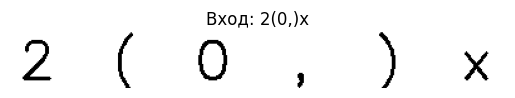

Результат распознавания: 848,43


In [10]:
print("\n=== Генерация датасета ===")
generate_dataset()

print("\n=== Загрузка тренировочных данных ===")
X_train, y_train = load_training_data()
print("Размер обучающей выборки:", len(X_train))

print("\n=== Обучение KNN ===")
models = train_knn_models(X_train, y_train)

print("\n=== Оценка моделей ===")
accs = evaluate_models(models)

best_k = max(accs, key=lambda k: accs[k])
print(f"\nЛучший k = {best_k}   (accuracy = {accs[best_k]:.3f})")

# демонстрация
print("\n=== Демонстрация распознавания ===")
test_text = generate_random_text()
test_img = generate_text_image(test_text)

plt.imshow(test_img, cmap='gray')
plt.title(f"Вход: {test_text}")
plt.axis('off')
plt.show()

recognized = classify_sequence(test_img, models[best_k])
print(f"Результат распознавания: {recognized}")